<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/deeplearningbro/deeplearningbro/pytorch

/content/drive/MyDrive/deeplearningbro/deeplearningbro/pytorch


In [ ]:
# CIFAR10 사용 torchvision datasets에서 제공해줌 10개의 클래스를 가진 이미지데이터
# 데이터 불러오기

# 텐서로 바꾸고 정규화
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is avaliable')

cuda:0 is avaliable


In [ ]:
# CNN모델구축
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)   # 합성곱 연산(입력 채널수, 출력 채널수, 필터크기, stride=1(defualt))
    self.pool1 = nn.MaxPool2d(2, 2)   # 합성곱 연산(필터크기, stride)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.pool2 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*5*5, 120)  # 5*5 피쳐맵 16개를 일렬로 핌, 히든레이어 120개
    self.fc2 = nn.Linear(120, 10)      # 120개의 노드에서 클래스 개수인 10개의 노드로 연산

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))   # conv1 -> relu -> pool1
    x = self.pool2(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)      # 5*5피쳐맵 16개를 일렬로 만듬
    x = F.relu(self.fc1(x))     
    x = F.relu(self.fc2(x))

    return x

net = Net().to(device)   # 모델선언

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

# Sequential을 사용하여 묶어서 할 수도 있다.
    self.feature_extraction = nn.Sequential(nn.Conv2d(3, 6, 5),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2, 2),
                                            nn.Conv2d(6, 16, 5),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2, 2))
    self.claaifier = nn.Sequential(nn.Linear(16*5*5, 120),
                                   nn.ReLU(),
                                   nn.Linear(120, 10),
                                   nn.ReLU())
    
  def forward(self, x):
    x = self.feature_extraction(x)
    x = x.view(-1, 16*5*5)
    x = self.classifier(x)

    return x
net = Net().to(device)

In [15]:
print(net)

Net(
  (feature_extraction): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (claaifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=10, bias=True)
    (3): ReLU()
  )
)


In [ ]:
# 모델 학습하기
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)   # 최적화기법 momentum사용

In [ ]:
loss_ = []
n = len(trainloader)

for epoch in range(10):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()

    outputs = net(inputs)       # 예측값 산출
    loss = criterion(outputs, labels)  # 손실함수 계산
    loss.backward()           # 손실함수 기준으로 역전파 선언
    optimizer.step()          # 가중치 최적화

    running_loss += loss.item()

  loss_.append(running_loss / n)       # 평균loss
  print('[%d] loss: %.3f'%(epoch+1, running_loss / len(trainloader)))

print('Finished Training')

[1] loss: 1.827
[2] loss: 1.383
[3] loss: 1.229
[4] loss: 1.133
[5] loss: 1.060
[6] loss: 0.999
[7] loss: 0.949
[8] loss: 0.904
[9] loss: 0.869
[10] loss: 0.832
Finished Training


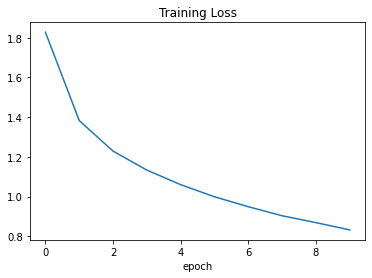

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
#모델 정확도 구하기
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000test images: %d %%" % (100*correct/total))

Accuracy of the network on the 10000test images: 64 %
